# First of all

Initialization

In [1]:
import ee

# Trigger the authentication flow.
# ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=W_s9qa_R9N29JKNFyMP7_vBrWNmlW0Ur4-IaV-Vk9CQ&tc=WCQgrVWbshbEQhkNwSwxQaIpVKnecXnFCPweCp-gYPc&cc=bNALK2R2VD4FLEbBzUmDd9kCs36cqG6P-pH7qkP6LRI

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1ARtbsJpsyIDfffX_eT3tqH_6St8OQbolqNCNiK_nTwtNRIcDMEQF9yHpNPM

Successfully saved authorization token.


In the Earth Engine Data Catalog, datasets can be of different types:

Features which are geometric objects with a list of properties. For example, a watershed with some properties such as name and area, is an ee.Feature.
Images which are like features, but may include several bands. For example, the ground elevation given by the USGS here is an ee.Image.
Collections which are groups of features or images. For example, the Global Administrative Unit Layers giving administrative boundaries is a ee.FeatureCollection and the MODIS Land Surface Temperature dataset is an ee.ImageCollection.

# Cloud remove

The technology of Earth observation has evolved considerably, and remote sensing (RS) imagery is the main method of technical analysis. RS is highly applicable to a wide variety of fields such as agricultural production, ecological construction, military reconnaissance and geological studies. However the reflected light from ground objects captured by optical sensors inevitably undergoes absorption and scattering from the atmosphere. Data detected by RS can be partially or even completely obscured by clouds, which hinders the implementation of global surveying and mapping missions, thus weakening the potential of RS for Earth exploration.



## Using GEE
Using google earth engine data involves to know what parametters to tune for better cleaning result. GEE helps masking clouds and cloud shadows in Sentinel-2 (S2) surface reflectance (SR) 

Clouds are identified from the S2 cloud probability dataset (s2cloudless) and shadows are defined by cloud projection intersection with low-reflectance near-infrared (NIR) pixels

list of parameters that are used to filter the S2 image collection and determine cloud and cloud shadow identification.

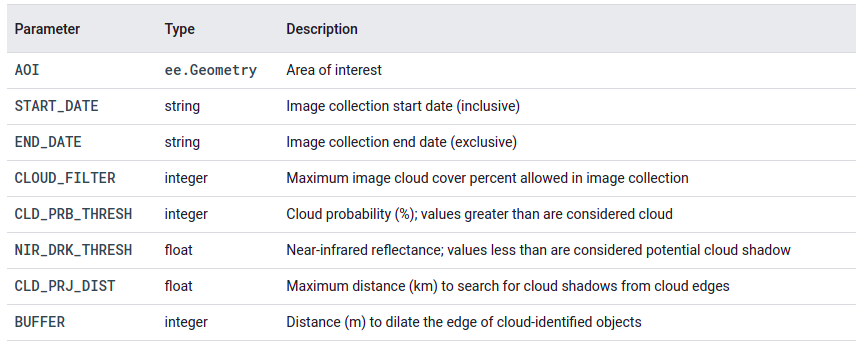

## Load Place

In [106]:
import pandas as pd
df_itally = pd.read_csv('/content/it.csv')
df_itally.head()

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
0,Rome,41.8931,12.4828,Italy,IT,Lazio,primary,2872800,2872800
1,Milan,45.4669,9.1900,Italy,IT,Lombardy,admin,1366180,1366180
2,Naples,40.8333,14.2500,Italy,IT,Campania,admin,966144,966144
3,Turin,45.0667,7.7000,Italy,IT,Piedmont,admin,870952,870952
4,Palermo,38.1157,13.3613,Italy,IT,Sicilia,admin,668405,668405


In [107]:
df_itally.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3373 entries, 0 to 3372
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   city               3373 non-null   object 
 1   lat                3373 non-null   float64
 2   lng                3373 non-null   float64
 3   country            3373 non-null   object 
 4   iso2               3373 non-null   object 
 5   admin_name         3373 non-null   object 
 6   capital            115 non-null    object 
 7   population         3373 non-null   int64  
 8   population_proper  3373 non-null   int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 237.3+ KB


In [108]:
italy_df =df_itally.drop(columns=['country','iso2','admin_name','capital','admin_name','population','population_proper'],axis=1)
italy_df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3373 entries, 0 to 3372
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   city    3373 non-null   object 
 1   lat     3373 non-null   float64
 2   lng     3373 non-null   float64
dtypes: float64(2), object(1)
memory usage: 79.2+ KB


In [109]:
selectCity_df=italy_df[italy_df['city']=='Milan']
selectCity_df

,city,lat,lng
1,Milan,45.4669,9.19


In [162]:
# city of Milan
# AOI = ee.Geometry.Point(selectCity_df['lng'].values[0], selectCity_df['lat'].values[0])
#A test with a region near Portland, Oregon, USA
AOI = ee.Geometry.Point(-122.269, 45.701)

START_DATE = '2020-06-01'
END_DATE = '2020-06-02'
CLOUD_FILTER = 60
CLD_PRB_THRESH = 50
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 1
BUFFER = 50



## Define functions

Before to joind two Sentinel Image collections it is better to filter them  similarly (e.g., by date and bounds) 

`get_s2_sr_cld_col ` function apply a threshold to remove some cloudy part of Sentinel images. It builds a collection according to the parameters defined above.

In [163]:
def get_s2_sr_cld_col(aoi, start_date, end_date):
    # Import and filter S2 SR.
    s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR')
        .filterBounds(aoi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER)))

    # Import and filter s2cloudless.
    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

In [164]:
s2_sr_cld_col_eval = get_s2_sr_cld_col(AOI, START_DATE, END_DATE)


Some times we prefer to create a mask that will be used to mask all part of pixels that are related to the cloud and add the cloud probability layer and cloud mask as image bands.

In [165]:
def add_cloud_bands(img):
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))

Let define a function to add dark pixels, cloud projection, and identified shadows as bands to an Sentinel 2 SR image input.

In [166]:
def add_shadow_bands(img):
    # Identify water pixels from the SCL band.
    not_water = img.select('SCL').neq(6)

    # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

    # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

In [167]:
def add_cld_shdw_mask(img):
    # Add cloud component bands.
    img_cloud = add_cloud_bands(img)

    # Add cloud shadow component bands.
    img_cloud_shadow = add_shadow_bands(img_cloud)

    # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
    # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
    is_cld_shdw = (is_cld_shdw.focalMin(2).focalMax(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    # Add the final cloud-shadow mask to the image.
    return img_cloud_shadow.addBands(is_cld_shdw)

## Define functions to display image and mask component layers

Folium will be used to display map layers. Import folium and define a method to display Earth Engine image tiles.

In [168]:
# Import the folium library.
import folium

# Define a method for displaying Earth Engine image tiles to a folium map.
def add_ee_layer(self, ee_image_object, vis_params, name, show=True, opacity=1, min_zoom=0):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        show=show,
        opacity=opacity,
        min_zoom=min_zoom,
        overlay=True,
        control=True
        ).add_to(self)

# Add the Earth Engine layer method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [169]:
def display_cloud_layers(col):
    # Mosaic the image collection.
    img = col.mosaic()

    # Subset layers and prepare them for display.
    clouds = img.select('clouds').selfMask()
    shadows = img.select('shadows').selfMask()
    dark_pixels = img.select('dark_pixels').selfMask()
    probability = img.select('probability')
    cloudmask = img.select('cloudmask').selfMask()
    cloud_transform = img.select('cloud_transform')

    # Create a folium map object.
    center = AOI.centroid(10).coordinates().reverse().getInfo()
    m = folium.Map(location=center, zoom_start=12)

    # Add layers to the folium map.
    m.add_ee_layer(img,
                   {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2500, 'gamma': 1.1},
                   'S2 image', True, 1, 9)
    m.add_ee_layer(probability,
                   {'min': 0, 'max': 100},
                   'probability (cloud)', False, 1, 9)
    m.add_ee_layer(clouds,
                   {'palette': 'e056fd'},
                   'clouds', False, 1, 9)
    m.add_ee_layer(cloud_transform,
                   {'min': 0, 'max': 1, 'palette': ['white', 'black']},
                   'cloud_transform', False, 1, 9)
    m.add_ee_layer(dark_pixels,
                   {'palette': 'orange'},
                   'dark_pixels', False, 1, 9)
    m.add_ee_layer(shadows, {'palette': 'yellow'},
                   'shadows', False, 1, 9)
    m.add_ee_layer(cloudmask, {'palette': 'orange'},
                   'cloudmask', True, 0.5, 9)

    # Add a layer control panel to the map.
    m.add_child(folium.LayerControl())

    # Display the map.
    display(m)

In [170]:
s2_sr_cld_col_eval_disp = s2_sr_cld_col_eval.map(add_cld_shdw_mask)

display_cloud_layers(s2_sr_cld_col_eval_disp)



```
Note that the layers have a minimum zoom level of 9 to avoid resource issues that can occur when visualizing layers that depend on the ee.
```



## Cloud-free composite for the same region

It is common to want obtain S2 images where cloud are removed in the same region for time series.

Define a function to apply the cloud mask to each image in the collection.

In [11]:
def apply_cld_shdw_mask(img):
    # Subset the cloudmask band and invert it so clouds/shadow are 0, else 1.
    not_cld_shdw = img.select('cloudmask').Not()

    # Subset reflectance bands and update their masks, return the result.
    return img.select('B.*').updateMask(not_cld_shdw)

In [171]:
AOI = ee.Geometry.Point(selectCity_df['lng'].values[0], selectCity_df['lat'].values[0])

START_DATE = '2020-06-01'
END_DATE = '2020-09-01'
CLOUD_FILTER = 60
CLD_PRB_THRESH = 40
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 2
BUFFER = 100

In [172]:
s2_sr_cld_col = get_s2_sr_cld_col(AOI, START_DATE, END_DATE)

Add cloud and cloud shadow component bands to each image and then apply the mask to each image. Reduce the collection by median.

In [173]:
s2_sr_median = (s2_sr_cld_col.map(add_cld_shdw_mask)
                             .map(apply_cld_shdw_mask)
                             .median())

## Display the cloud-free composite

Understanding how Earth Engine handles scale is crucial to interpreting scientific results obtained from Earth Engine. Here, scale means pixel resolution. Unlike other GIS and image processing platforms, the scale of analysis is determined from the output, rather than the input. Specifically, when you make a request for results, an image to display or a statistic, for example, you specify the scale at which data is input to the analysis.

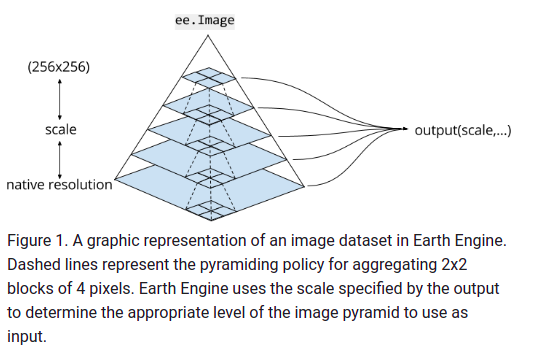

Display the results. Be patient while the map renders, it may take a minute; ee.Image.reproject is forcing computations to happen at 100 and 20 m scales (i.e. it is not relying on appropriate pyramid level scales for analysis). 

In [174]:
# Create a folium map object.
center = AOI.centroid(10).coordinates().reverse().getInfo()
m = folium.Map(location=center, zoom_start=12)

# Add layers to the folium map.
m.add_ee_layer(s2_sr_median,
                {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2500, 'gamma': 1.1},
                'S2 cloud-free mosaic', True, 1, 9)

# Add a layer control panel to the map.
m.add_child(folium.LayerControl())

# Display the map.
display(m)

# Vegetation management

## Phenological metrics computing

In [175]:
def getNDVI(image):
    
    # Normalized difference vegetation index (NDVI)
    ndvi = image.normalizedDifference(['B8','B4']).rename("NDVI")
    image = image.addBands(ndvi)

    return(image)

In [176]:
def getEVI(image):
   # Compute the EVI using an expression.
    EVI = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
            'NIR': image.select('B8').divide(10000),
            'RED': image.select('B4').divide(10000),
            'BLUE': image.select('B2').divide(10000)
        }).rename("EVI")

    image = image.addBands(EVI)

    return(image)

In [177]:
#add date foramte
def addDate(image):
    img_date = ee.Date(image.date())
    img_date = ee.Number.parse(img_date.format('YYYYMMdd'))
    return image.addBands(ee.Image(img_date).rename('date').toInt())

In [178]:
Sentinel_data=s2_sr_cld_col.map(getNDVI).map(getEVI).map(addDate)

In [179]:
s2_sr_median = (Sentinel_data.map(add_cld_shdw_mask)
                             .map(apply_cld_shdw_mask)
                             .median())

In [180]:
Sentinel_data = ee.ImageCollection('COPERNICUS/S2') \
    .filterDate("2020-01-01","2021-08-31") \
    .map(getNDVI).map(getEVI).map(addDate)

## Convert the pandas dataframe into Google Earth Engine (GEE) Feature Collection

In [181]:
features=[]
for index, row in selectCity_df.iterrows():
    poi_geometry = ee.Geometry.Point([row['lat'], row['lng']])
#     print(poi_geometry)
#     construct the attributes (properties) for each point 
    poi_properties = dict(row)
#     construct feature combining geometry and properties
    poi_feature = ee.Feature(poi_geometry, poi_properties)
    features.append(poi_feature)

    # final Feature collection assembly
ee_fc = ee.FeatureCollection(features) 
ee_fc.getInfo()

{'type': 'FeatureCollection',
 'columns': {'city': 'String',
  'lat': 'Float',
  'lng': 'Float',
  'system:index': 'String'},
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Point', 'coordinates': [45.4669, 9.19]},
   'id': '0',
   'properties': {'city': 'Milan', 'lat': 45.4669, 'lng': 9.19}}]}

In [182]:
def rasterExtraction(image):
    feature = image.sampleRegions(
        collection = ee_fc, # feature collection here
        scale = 10 # Cell size of raster
    )
    return feature

In [183]:
results = (Sentinel_data.filterBounds(ee_fc)                            
                              .select('NDVI', 'EVI').map(addDate).map(rasterExtraction).flatten() )
# s2_sr_median = (Sentinel_data.map(add_cld_shdw_mask)
#                              .map(apply_cld_shdw_mask)
#                              .median())

In [184]:
sample_result = results.first().getInfo()
sample_result

{'type': 'Feature',
 'geometry': None,
 'id': '20200103T072309_20200103T073627_T38PNR_0_0',
 'properties': {'EVI': 0.084138360860081,
  'NDVI': 0.11667266488075256,
  'city': 'Milan',
  'date': 20200103,
  'lat': 45.4669,
  'lng': 9.19}}

In [185]:
# extract the properties column from feature collection
# column order may not be as our sample data order
columns = list(sample_result['properties'].keys())
print(columns)


# Order data column as per sample data
# You can modify this for better optimization
column_df = list(italy_df.columns)
column_df.extend(['NDVI', 'EVI', 'date'])
print(column_df)

['EVI', 'NDVI', 'city', 'date', 'lat', 'lng']
['city', 'lat', 'lng', 'NDVI', 'EVI', 'date']


In [186]:
nested_list = results.reduceColumns(ee.Reducer.toList(len(column_df)), column_df).values().get(0)
data = nested_list.getInfo()
data

# dont forget we need to call the callback method "getInfo" to retrieve the data
df = pd.DataFrame(data, columns=column_df)
# we obtain the data frame as per our demand
df


,city,lat,lng,NDVI,EVI,date
0,Milan,45.4669,9.19,0.116673,0.084138,20200103
1,Milan,45.4669,9.19,0.114676,0.100244,20200108
2,Milan,45.4669,9.19,0.068176,0.051681,20200113
3,Milan,45.4669,9.19,0.116933,0.084349,20200118
4,Milan,45.4669,9.19,0.103848,0.073476,20200123
...,...,...,...,...,...,...
117,Milan,45.4669,9.19,0.085865,0.063922,20210810
118,Milan,45.4669,9.19,0.004214,0.011039,20210815
119,Milan,45.4669,9.19,0.079640,0.057649,20210820
120,Milan,45.4669,9.19,0.079004,0.055933,20210825
